In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from qa_summer.QSVR import QSVR
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import train_test_split
from utils import nb_utils
from joblib import dump, load
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import datetime
from random import randint, random
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR

## Load Saved Model and data

In [24]:
model_dict = load('../results/good_qsvr/chain_str_10/qsvr_attrs_eric_params_chain_10_hp_search_rs965737426_i0.joblib')
rs = 965737426

# load data
df_info = nb_utils.get_df_info('mlpf')
df = pd.read_csv(df_info['df_path'])
df = df.drop(df[df.loss_99 == df.loss_99.max()].index)

# Select features
curve = nb_utils.get_curve(df_info=df_info, known_curve=0.25, df=df)
X = curve[:,[i for i in range(0,curve.shape[1],2)]]

# Prediction target
y = nb_utils.get_target(df_info,df)

# Scale data: USE THE SAME SCALER THAT WAS USED FOR TRAINING THE SAVED MODEL
x_scaler = QuantileTransformer(n_quantiles=50,random_state=0)
X = x_scaler.fit_transform(X)
y_scaler =  QuantileTransformer(n_quantiles=50,random_state=0)
y = y_scaler.fit_transform(y.reshape(-1, 1)).ravel()
_, X_test, _, y_test = train_test_split(X, y, test_size=0.5, random_state=rs)

## Make a prediction with the saved model

In [25]:
# instantiate a QSVR that can be used to do predictions
pred_model = QSVR.QSVR() 
# set the QSVR attributes needed for predictions
for attr in model_dict.keys():
    setattr(pred_model, attr, model_dict[attr])

# use the QSVR to do a prediction
# loaded scalers may be needed
y_pred = pred_model.predict(X_test)

## Plot

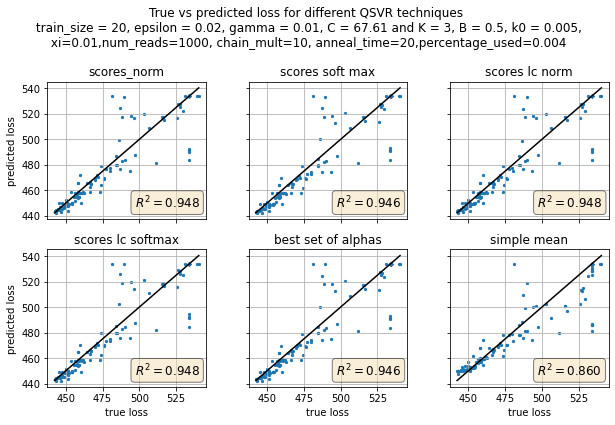

In [26]:
fig, axs = plt.subplots(2,3,figsize=(9, 6))
fig.suptitle("True vs predicted loss for different QSVR techniques\n train_size = 20, epsilon = 0.02, gamma = 0.01, C = 67.61 and K = 3, B = 0.5, k0 = 0.005,\n xi=0.01,num_reads=1000, chain_mult=10, anneal_time=20,percentage_used=0.004\n")
fig.tight_layout()

for ax in axs.flat:
    ax.set(xlabel='true loss', ylabel='predicted loss')
    ax.grid()

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

x = y_scaler.inverse_transform(y_test.reshape(-1, 1))

methods = ['scores_norm', 'scores soft max', 'scores lc norm', 'scores lc softmax', 'best set of alphas', 'simple mean']
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
for i in range(y_pred.shape[0]-1):
    y = y_scaler.inverse_transform(y_pred[i,:].reshape(-1, 1))
    axs.flat[i].scatter(x,y,s=5)
    axs.flat[i].plot([x.min(),x.max()],[x.min(),x.max()],'k')
    axs.flat[i].set_title(methods[i])
    axs.flat[i].text(0.55, 0.18,'$R^2=$'+"{:.3f}".format(r2_score(y_pred[i,:],y_test)), transform=axs.flat[i].transAxes, fontsize=12,
        verticalalignment='top', bbox=props)
plt.gcf().subplots_adjust(bottom=0.1, left=0.1)
plt.savefig("../results/mlpf_loss_qsvr.png",dpi=300)
plt.show()